# Density contrast cross validation
The choice of the density value used in the inversion directly affects the results and therefore needs to be carefully chosen. Choosing too high of a density contrast will result in a low amplitude topography, and too low of a value will result in a topography with high amplitude features. Similar to choosing an optimal damping value in `damping_cross_validation.ipynb`, we provides some tools to best choose the density contrast value.

However, this cross validation is slightly different than the damping cross validation in that we need at least 1 location where we know the true topography. These locations could be from seismic surveys, drill sites etc. These points of known topography are referred to as `constraint points`.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2


import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from antarctic_plots import maps
from antarctic_plots import utils as ap_utils

from invert4geom import cross_validation, inversion, plotting, synthetic, utils

/home/matt/invert4geom/src/invert4geom/cross_validation.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Create observed gravity data

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Constraint points

Sample the starting topography at 10 random locations to create a set of constraints points, simulating locations where the topography is known.

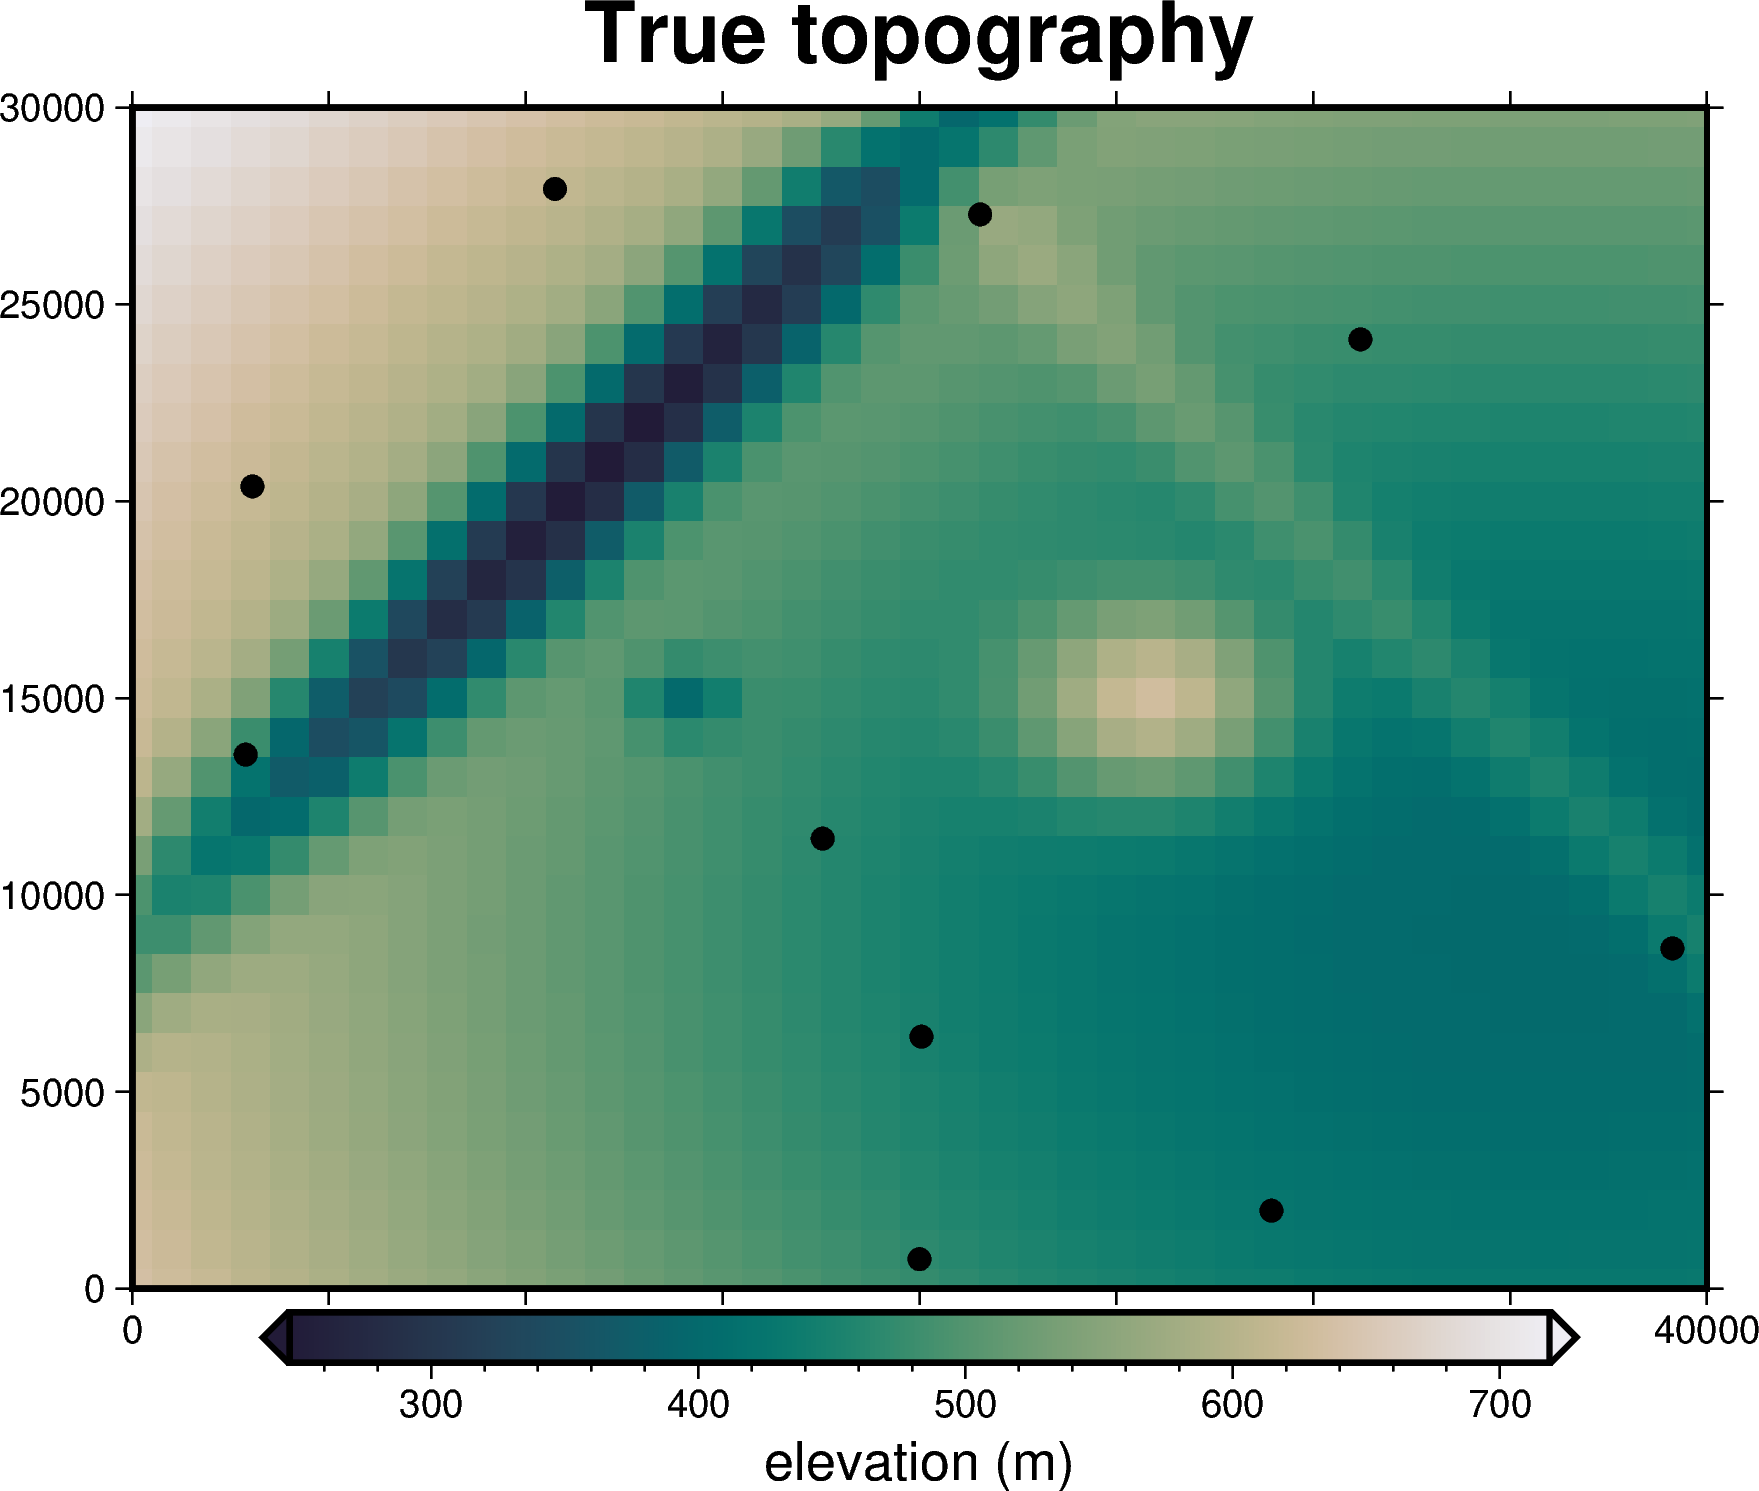

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)
fig.show()

### True topography prism layer

In [4]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()
print(f"mean of true topography: {zref} m ")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

mean of true topography: 492.2704164812973 m 


### Forward gravity of prism layer

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


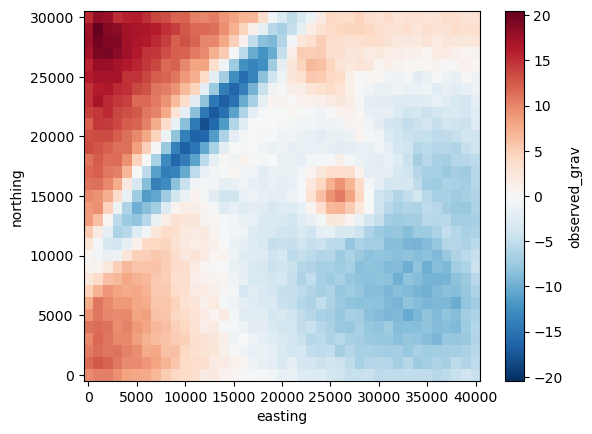

In [6]:
# contaminate gravity with 1 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

For simplicity here we assume that we know reference level `zref` of the true topography, and use this when creating our starting model.

What we don't know in this scenario is what value to use for the density contrast. We will use a cross-validation of a range of density values to find the one which is optimal.

Each density value will give a cross validation score, and the lowest score will show which density value is optimal. 

The cross validation score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points. 

## Get Cross Validation Score

First we need to use the density value to create the flat starting model. We will then use this in an inversion to calculate a `score`.


In [7]:
# set a density contrast
density_contrast = 2300  # compared to true value of 2669

# assume we know the optimal zref value
zref = true_topography.values.mean()

# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["observed_grav"]
grav_df["reg"] = 0
grav_df["res"] = grav_df.misfit

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "solver_damping": 0.1,
    "zref": zref,
    "density_contrast": density_contrast,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.005,
}

# run inversion, calculate the score
score = cross_validation.constraints_cv_score(
    grav=grav_df,
    constraints=constraint_points,
    **kwargs,
)
score

15.307584112536286

## Cross Validation
Let se if we can improve the score with other values for the density contrast. 

Now we can repeat this with a range of density contrast values to find the optimal (lowest) score. But remember we need to recreate the starting model with each density value.

In [13]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set which density contrasts to include
density_contrasts = np.linspace(2400, 3000, 8)

# run inversions and collect scores
scores = []
for density_contrast in density_contrasts:
    # re-calculate density grid with new density contrast
    density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_topography,
        zref,
        density=density,
    )

    # update density contrast value in kwargs
    kwargs["density_contrast"] = density_contrast

    # update starting model in kwargs
    kwargs["prism_layer"] = starting_prisms

    # run cross validation
    score = cross_validation.constraints_cv_score(
        grav=grav_df,
        constraints=constraint_points,
        **kwargs,
    )
    scores.append(score)

# print damping and score pairs
for density_contrast, score in zip(density_contrasts, scores):
    print(f"Density contrast: {density_contrast} -> Score: {score}")

best_idx = np.argmin(scores)
best_score = scores[best_idx]
best_density_contrast = density_contrasts[best_idx]
print(f"Best score of {best_score} with density contrast={best_density_contrast}")

Density contrast: 2400.0 -> Score: 12.146992321104095
Density contrast: 2485.714285714286 -> Score: 9.68314924776792
Density contrast: 2571.4285714285716 -> Score: 7.729267747109761
Density contrast: 2657.142857142857 -> Score: 6.239270135848094
Density contrast: 2742.8571428571427 -> Score: 5.404648028861726
Density contrast: 2828.5714285714284 -> Score: 5.369994982535395
Density contrast: 2914.285714285714 -> Score: 6.029795434562008
Density contrast: 3000.0 -> Score: 7.111292687879829
Best score of 5.369994982535395 with density contrast=2828.5714285714284


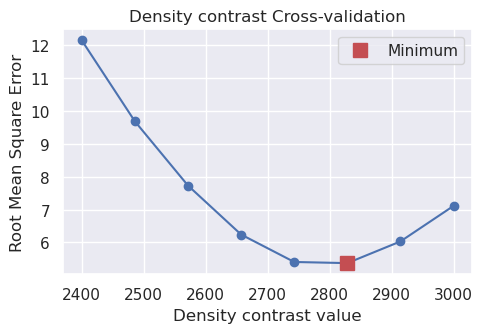

In [14]:
plotting.plot_cv_scores(
    scores,
    density_contrasts,
    param_name="Density contrast",
    # logx=True,
    # logy=True,
)

## Run inversion with optimal value

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0
INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -5.9354 m, RMSE:34.004 m
INFO:root:updated misfit RMSE: 3.8649
INFO:root:updated L2-norm: 1.9659, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.3605, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 11.9234 m, RMSE:17.9204 m
INFO:root:updated misfit RMSE: 2.2018
INFO:root:updated L2-norm: 1.4838, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.3249, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 6.2933 m, RMSE:9.8122 m
INFO:root:updated misfit RMSE: 1.3524
INFO:root:updated L2-norm: 1.1629, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.276, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 3.4011 m, RMSE:5.663

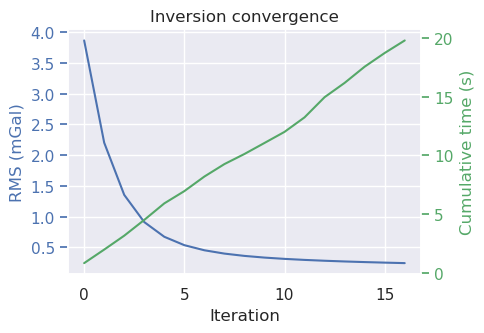

In [15]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# re-calculate density grid with the best density contrast
density_contrast = best_density_contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# update starting model in kwargs
kwargs["prism_layer"] = starting_prisms

# make new kwargs without zref or density
new_kwargs = {
    key: value
    for key, value in kwargs.items()
    if key
    not in [
        "zref",
        "density_contrast",
    ]
}
results = inversion.run_inversion(
    input_grav=grav_df,
    plot_convergence=True,
    zref=kwargs.get("zref"),
    density_contrast=density_contrast,
    **new_kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


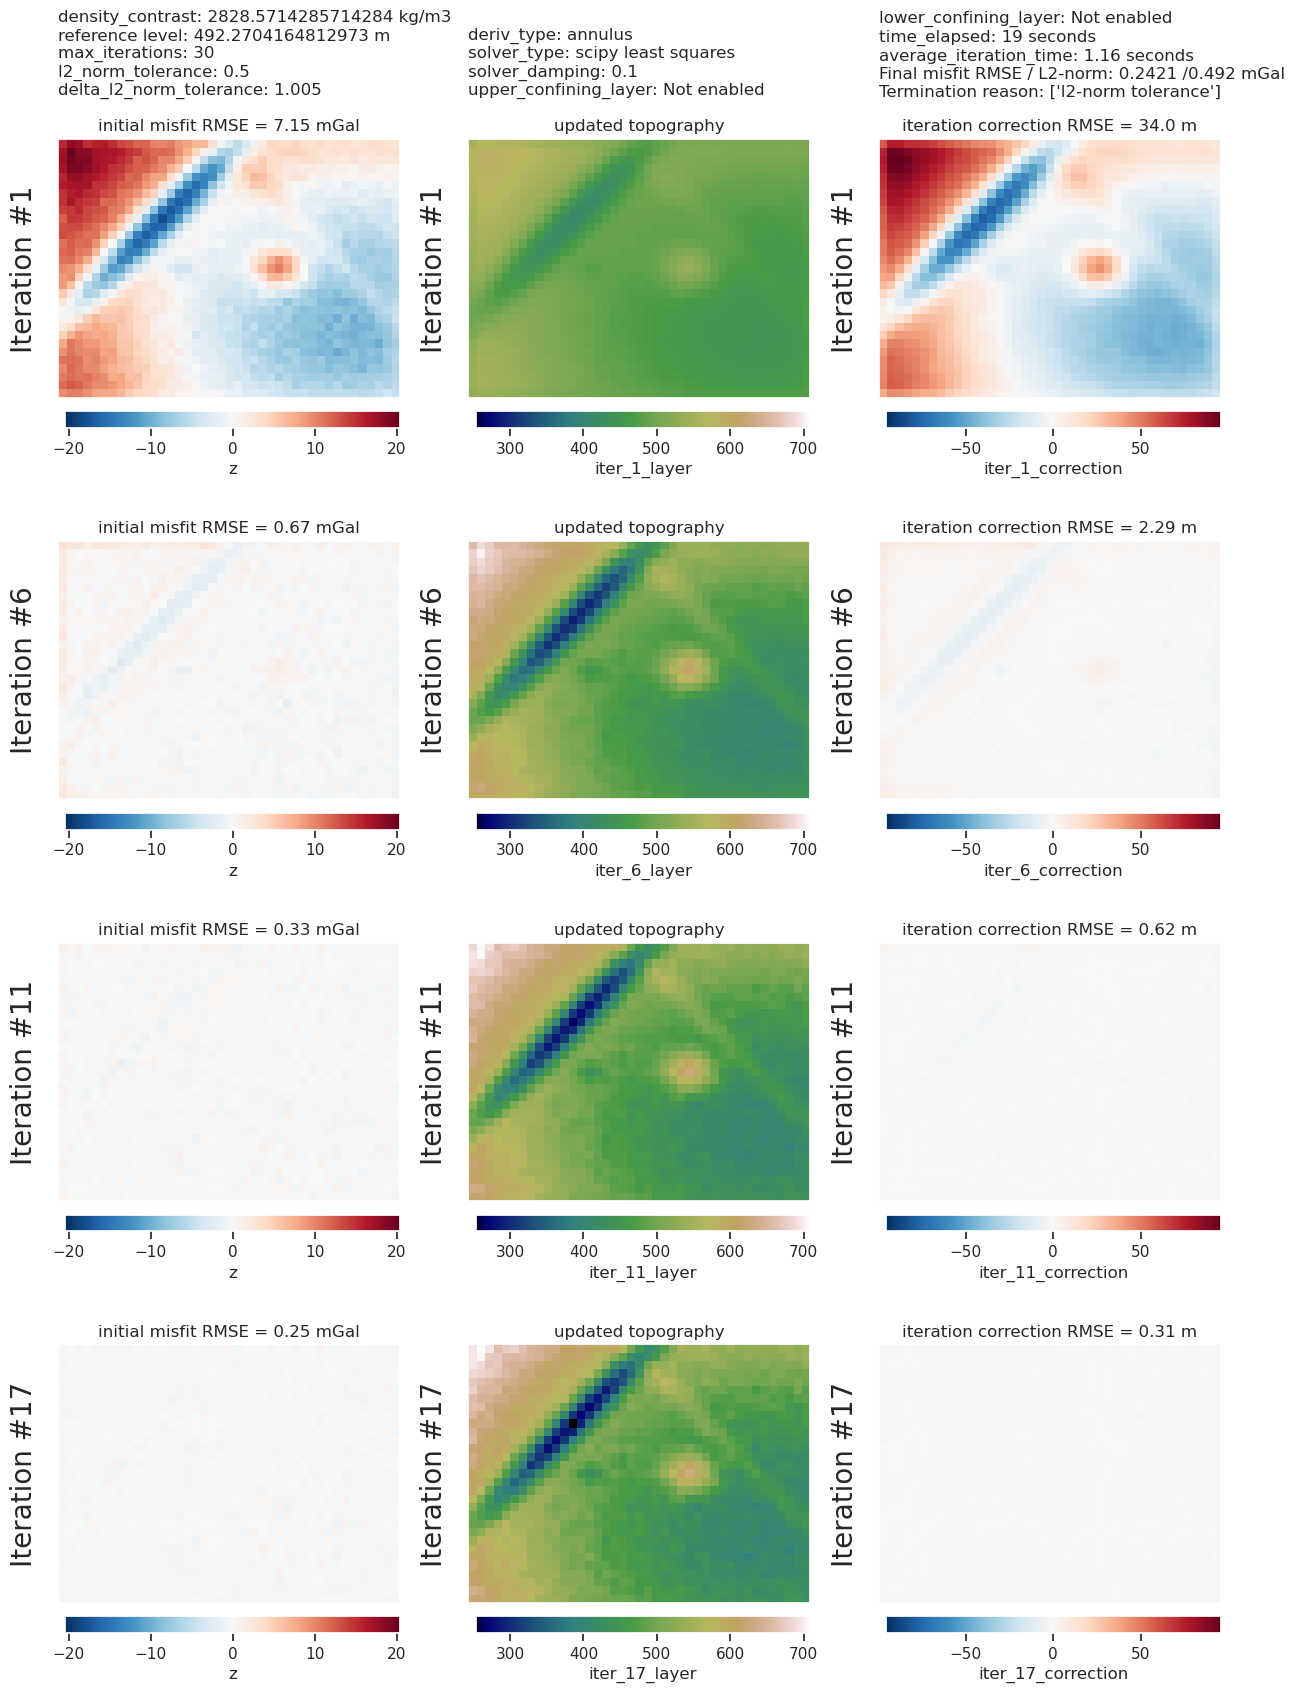

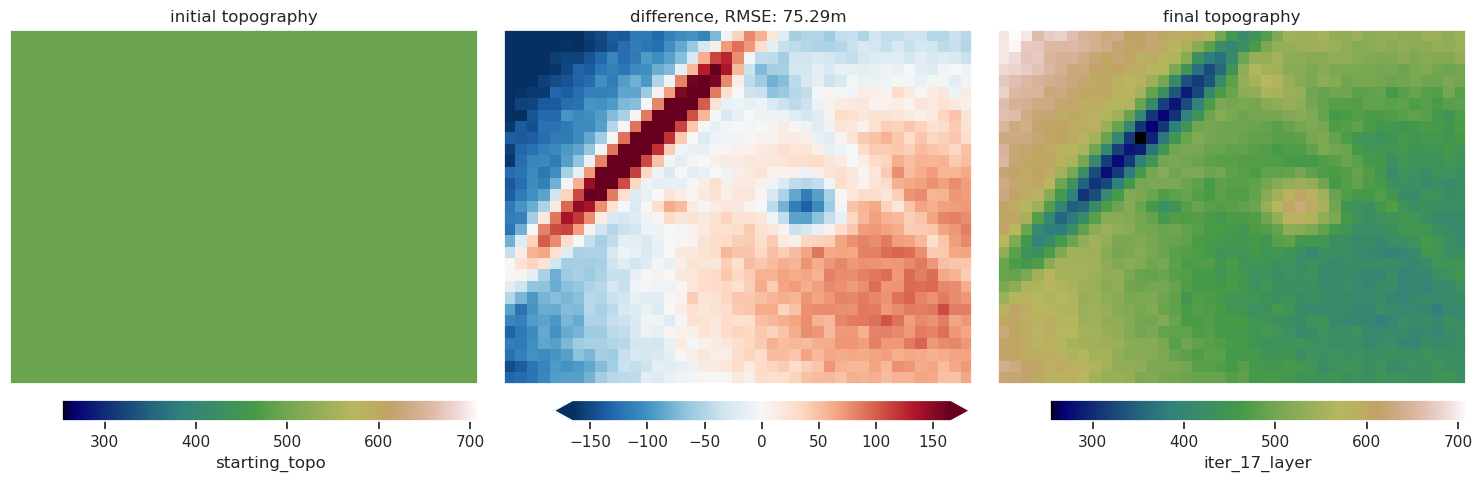

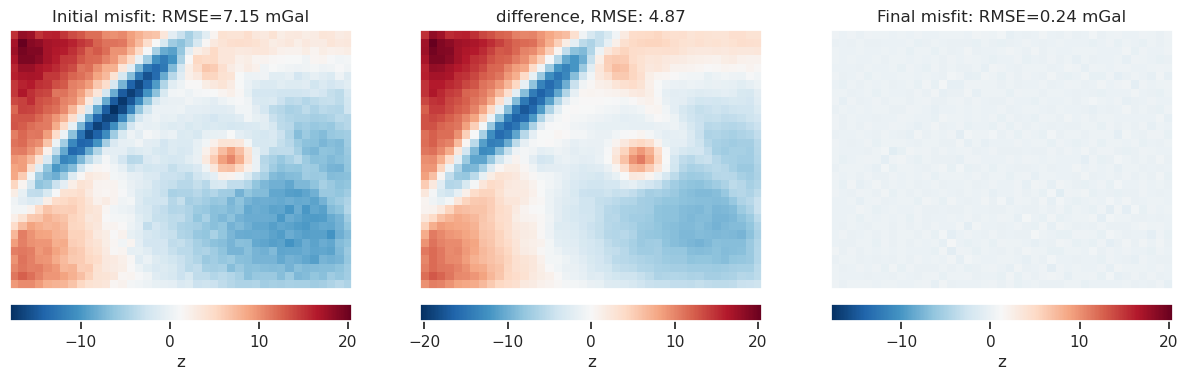

In [16]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


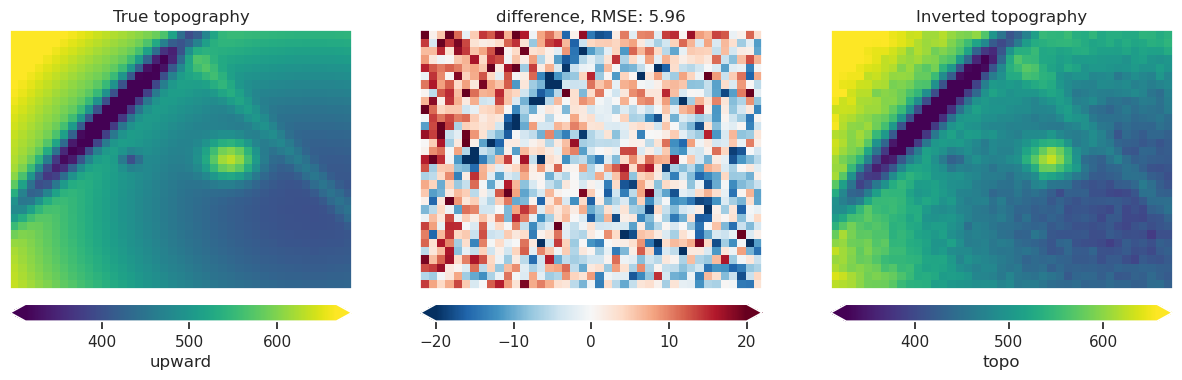

In [17]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
)

#